# Assignment-2: Manifold Learning

The objective of this assignment is to apply the concepts you have learned in class on Manifold Learning and Spectral Clustering. 

## Instructions
  - For each question you need to write the sub-problem formulation in markdown. 
  - Ensure that this notebook runs without errors when the cells are run in sequence.
  - Plagiarism will not be tolerated.
  - Use only `python3` to run your code.
  - If you are facing issues running the notebook on your local system. Use google collab to run the notebook online. To run the notebook online, go to [google collab](!https://colab.research.google.com/notebooks/intro.ipynb). Go to `File  -> Upload Notebook` and import the notebook file.

__NOTE__: If you use online platforms, you will have to upload `swissroll.dat` file separately and change the path in the code cell which loads the data.

## Submission  
- Rename the notebook to `<roll_number>.ipynb` and submit **ONLY** the notebook file on moodle.

## Problems 
 - Question 1: Spectral Clustering (10 marks)
 - Question 2: Manifold Visualization (10 marks)
 - Question 3: Clustering and Visualizing high-dimensional data (10 marks)
 - Question 4: Classification (10 marks)

## Deadline 
The deadline of this assignment is 27th April, 2020, 11:59 PM

In [1]:
import sys
# Install packages correctly
!{sys.executable} -m pip install numpy sklearn tensorflow keras
# Fix mpl version due to subtle API differences
!{sys.executable} -m pip install matplotlib==3.0.3

import numpy
# Allow usage of both `np` and `numpy`
np = numpy
import sklearn
import matplotlib

In [2]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.neighbors import kneighbors_graph
from sklearn.utils import graph_shortest_path

# Display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from IPython.display import display

# Data
import sklearn.manifold as manifold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Classification models
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

# Question 1: Spectral Clustering

Implement spectral clustering and evaluate on the given concentric circles dataset for this question.

## Part 1: Implementation
Implement spectral clustering function from scratch (for two clusters), taking as input the dataset. It must return the predicted clustering. Assume that the graph constructed is a fully connected graph. Use the normalized graph laplacian for this case.



In [3]:
# Part 1: Spectral Clustering

def spectral_clustering(X, i=1):
    """Args:
        X: numpy.array [num_samples, input_dim]

        Returns:
        Y_pred: numpy.array [num_samples]
          array of cluster labels
    """
    sigma = 0.1
    A = kneighbors_graph(X=X, n_neighbors=X.shape[0]-1, mode="distance", include_self=False).toarray()
    A = np.exp(-(A ** 2) / (2 * sigma ** 2))
    np.fill_diagonal(A, 0)
    
    D = np.diagflat(np.sum(A, axis=1))
    D_1 = np.sqrt(np.linalg.pinv(D))
    
    L = np.identity(A.shape[0]) - (D_1 @ A @ D_1)
    
    E, V = np.linalg.eigh(L)
    
    f = V[:, 1]
    Y_pred = (f < 0).astype(int)
    Y_pred = Y_pred.T
    return Y_pred

## Part 2: Clustering concentric circles
Perform spectral clustering on the concentric circles dataset. Visualize the result by plotting it on a 2-d graph. Use different colours for different clusters.

In [4]:
# DO NOT EDIT

from sklearn.datasets import make_circles 

CX, CY = make_circles(n_samples=200, shuffle=True,noise=0.05, random_state=1337, factor=0.5)
# CX: input data points [n_samples, 2]
# CY: true clusters [n_samples]

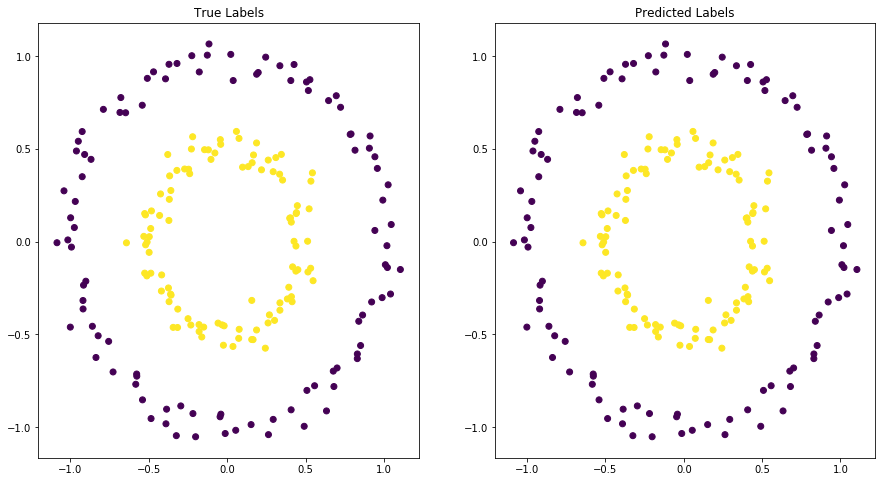

In [5]:
# Part 2: Perform Spectral Clustering on the concentric circles dataset
# Plot using colors from CY (true clusters) and CY_pred (predicted clusters)
# Code in this cell should plot 2 subplots (true labels and predicted labels)
CY_pred = spectral_clustering(CX)
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.scatter(CX[:, 0], CX[:, 1], c=CY)
plt.title('True Labels')

plt.subplot(1, 2, 2)
plt.scatter(CX[:, 0], CX[:, 1], c=CY_pred)
plt.title('Predicted Labels')
plt.show()

## Part 3: Evaluate accuracy
Evaluate the accuracy of the clustering by comparing it with the true labels. Create two subplots (true vs predicted) with the color of each point showing the cluster label.

In [6]:
# Part 3: Report the accuracy of clustering
accuracy = accuracy_score(y_true=CY, y_pred=CY_pred)
if accuracy == 0:
    accuracy = 1
print('Accuracy: {}%'.format(accuracy * 100))

Accuracy: 100.0%




---



# Question 2: Manifold Visualization
Implement the various manifold learning methods and visualize the given datasets.


## Part 1: MDS
Implement Multi-Dimensional Scaling

In [7]:
# Part 1: MDS

def MDS(X, k, output_dim=2):
    """Args:
        X: numpy.array [n_samples, input_dim]
        k: number of nearest neighbours to construct the knn graph
        p: dimension of output data

        Returns:
        Y: numpy.array [n_samples, p]
    """
    n, d = X.shape
    p = output_dim
    D = kneighbors_graph(X=X, n_neighbors=n-1, mode="distance", include_self=False)
    H = np.identity(n) - (1 / n) * np.ones((n, n))
    K = -0.5 * H @ D @ H
    E, V = np.linalg.eigh(K)
    E = E[::-1]
    V = V[:, ::-1]
    L = np.diagflat(np.sqrt(E[:p]))
    Y = V[:, :p] @ L
    return Y

## Part 2: LLE
Implement Locally Linear Embedding function

In [8]:
# Part 2: LLE

def LLE(X, k, output_dim=2):
    """Args:
        X: numpy.array [n_samples, input_dim]
        k: number of nearest neighbours to construct the knn graph
        output_dim: dimension of output data

        Returns:
        Y: numpy.array [n_samples, output_dim]
    """
    n, d = X.shape
    p = output_dim
    graph = kneighbors_graph(X=X, n_neighbors=k, mode="connectivity", include_self=False)
    graph = graph.toarray()
    W = np.zeros((n, n))
    for i in range(X.shape[0]): 
        x = X[i, :].reshape(d, 1) @ np.ones(k).reshape(1, k)
        index = np.where(graph[i, :] == 1)[0]
        v = X[index, :].T
        G = (x - v).T @ (x - v)
        w = np.linalg.pinv(G) @ np.ones(k).reshape(k, 1)
        w = w / np.sum(w)
        W[index, i] = w.T[0, :]
    m = np.identity(n) - W
    M = m @ m.T
    E, V = np.linalg.eigh(M)
    Y = V[:, 1:p+1]
    return Y

## Part 3: ISOMAP
Implement Isomap Visualization  

In [9]:
# Part 3: Isomap

def ISOMAP(X, k, output_dim=2):
    """Args:
        X: numpy.array [n_samples, input_dim]
        k: number of nearest neighbours to construct the knn graph
        output_dim: dimension of output data

        Returns:
        Y: numpy.array [n_samples, output_dim]
    """
    n, d = X.shape
    p = output_dim
    graph = kneighbors_graph(X=X, n_neighbors=k, mode="distance", include_self=False)
    D = graph_shortest_path.graph_shortest_path(graph, directed=False) ** 2
    H = np.identity(n) - (1 / n) * np.ones((n, n))
    K = -0.5 * H @ D @ H
    E, V = np.linalg.eigh(K)
    E = E[::-1]
    V = V[:, ::-1]
    L = np.diagflat(np.sqrt(E[:p]))
    Y = V[:, :p] @ L
    return Y

## Part 3: Manifold Visualization
Visualize the S-shaped 3-d dataset using the MDS, ISOMAP, LLE

In [10]:
# DO NOT EDIT

from sklearn import manifold, datasets

SX, St = datasets.make_s_curve(n_samples=1000, random_state=1337)
# SX: input data [n_samples, 3]
# St: univariate position along manifold [n_samples], use for coloring the plots

The code in the next cell should draw a single plot with the following subplots:
1. 3D S-shaped dataset
2. 2D Manifold learnt using MDS
3. 2D Manifold learnt using ISOMAP
4. 2D Manifold learnt using LLE

Use the `St` variable to color the points in your visualizations. Use a color spectrum, and the position along the manifold to assign the color.

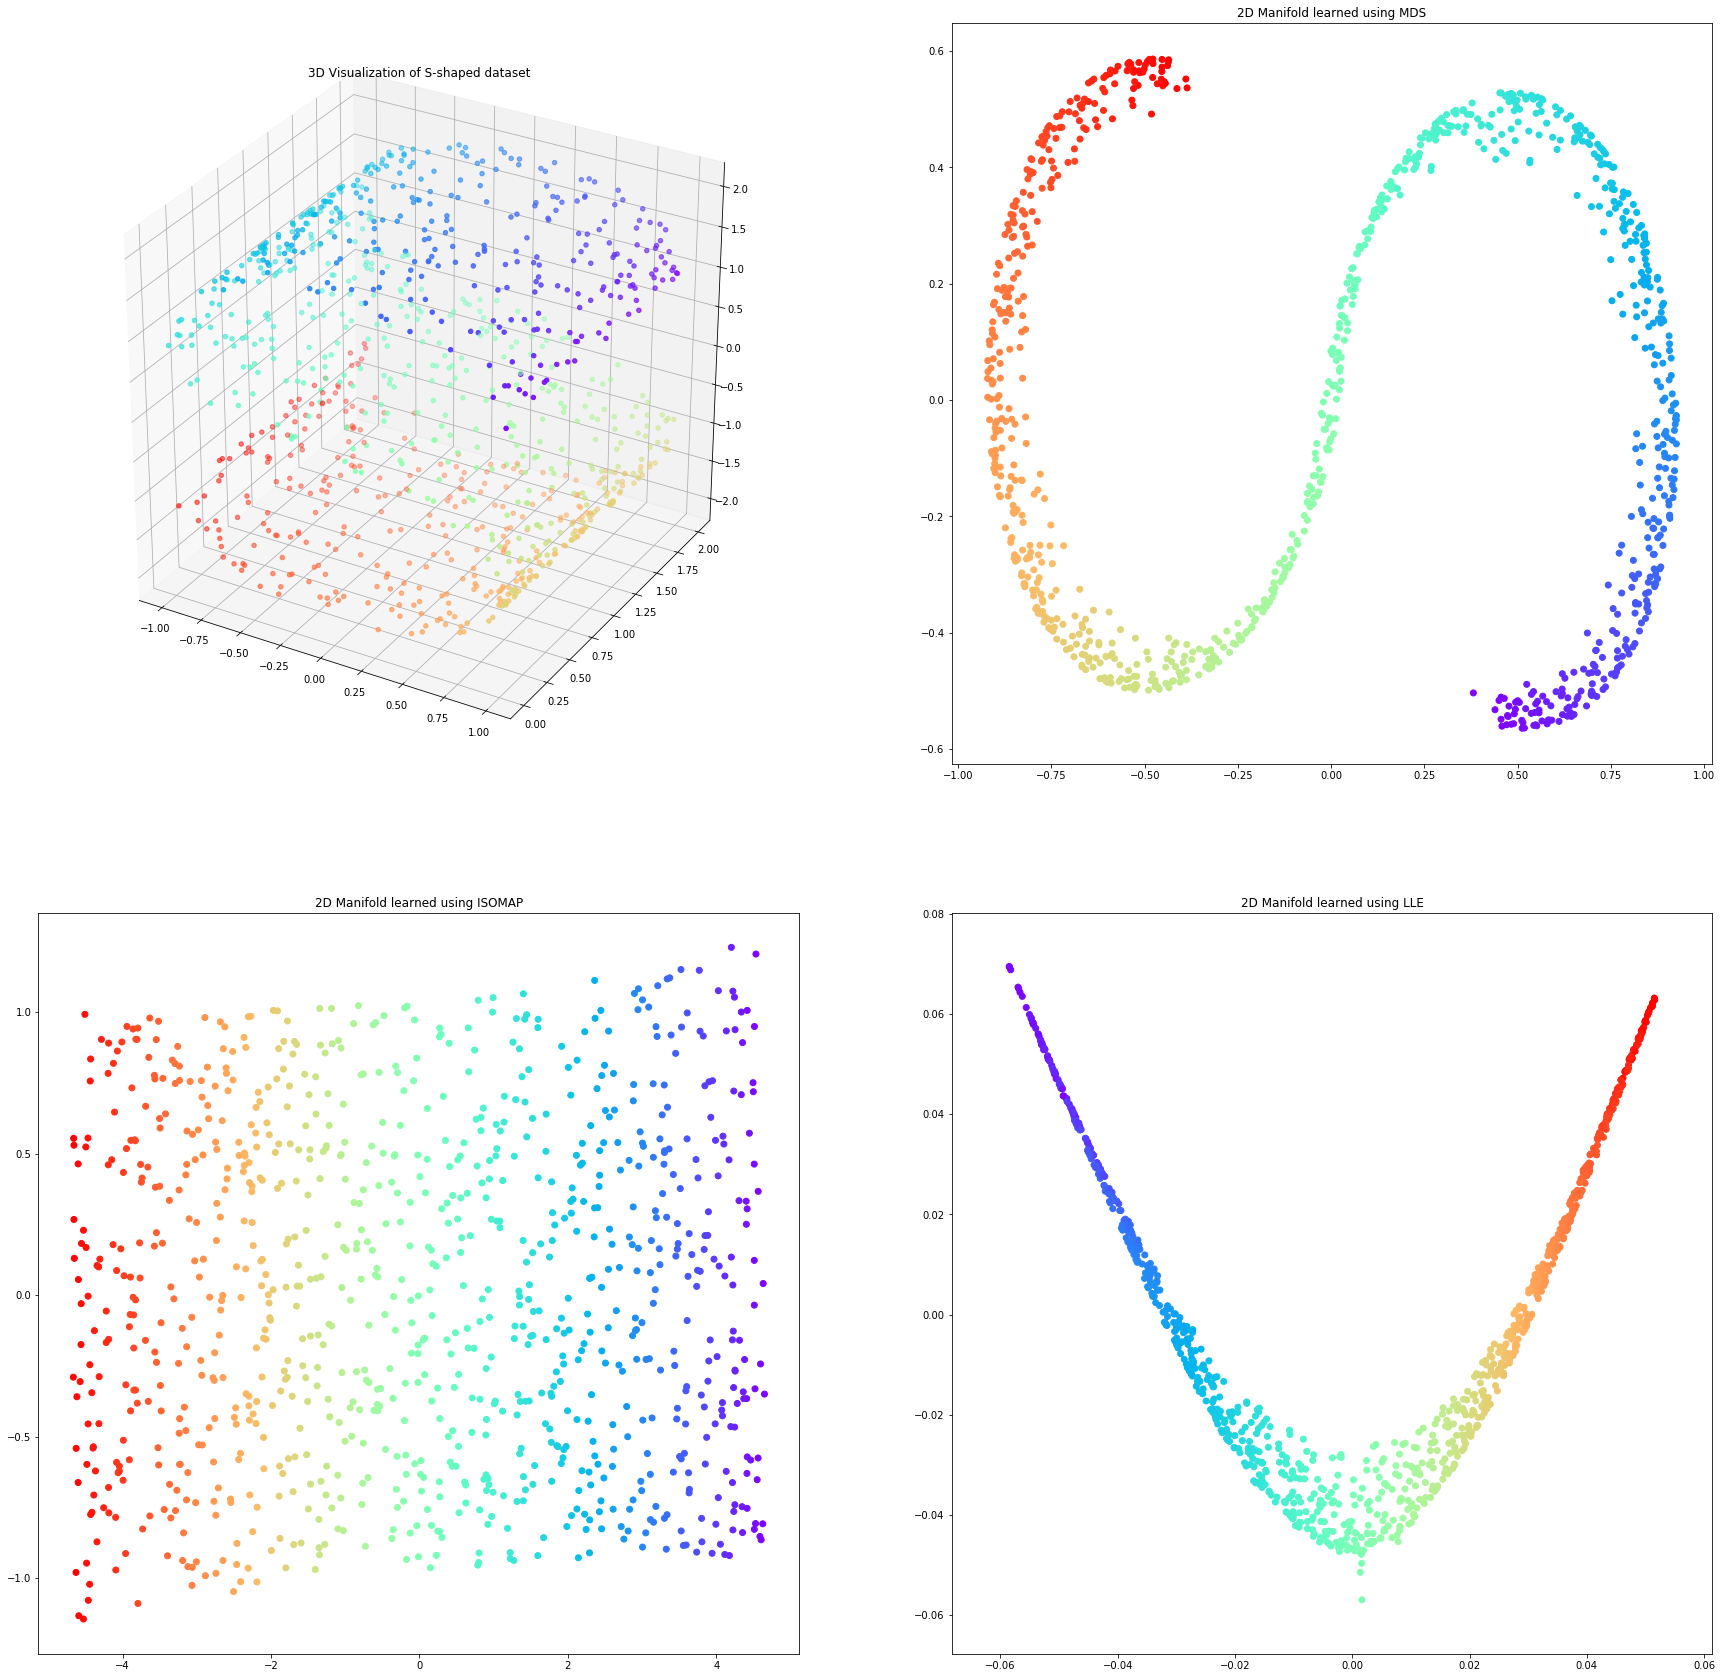

In [11]:
#  Visualization code here
mds = MDS(SX, SX.shape[0]-1)
isomap = ISOMAP(SX, 50)
lle = LLE(SX, 50)

colorize = dict(c=St, cmap=plt.cm.get_cmap('rainbow', len(St)))

fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.scatter3D(SX[:, 0], SX[:, 1], SX[:, 2], **colorize)
ax.set_title('3D Visualization of S-shaped dataset')

ax = fig.add_subplot(2, 2, 2)
ax.scatter(mds[:, 0], mds[:, 1], **colorize)
ax.set_title('2D Manifold learned using MDS')

ax = fig.add_subplot(2, 2, 3)
ax.scatter(isomap[:, 0], isomap[:, 1], **colorize)
ax.set_title('2D Manifold learned using ISOMAP')

ax = fig.add_subplot(2, 2, 4)
ax.scatter(lle[:, 0], lle[:, 1], **colorize)
ax.set_title('2D Manifold learned using LLE')

plt.show()


# Question 3: Clustering and Visualizing high-dimensional data
Perform k-means and spectral clustering on the Swiss roll dataset and visualize using the above 3 methods. State your observations.

In [12]:
# Swiss roll dataset loading here
d = []
with open('./swissroll.dat', 'r') as dat_file:
    for line in dat_file:
        line = line.strip().split()
        line = [float(x.strip()) for x in line]
        d.append(line)
swissroll = numpy.array(d)
print (swissroll.shape)

(1600, 3)


Procedure for this question:
1. Perform spectral clustering (2 clusters) on the unchanged Swiss roll and visualize (binary colors)
2. Unwrap the manifold in 2D and visualize using
  - MDS
  - ISOMAP
  - LLE

Use the labels from the spectral clustering to color the unwrapped manifolds.

In [13]:
mds = MDS(swissroll, swissroll.shape[0]-1)
isomap = ISOMAP(swissroll, 50)
lle = LLE(swissroll, 50)

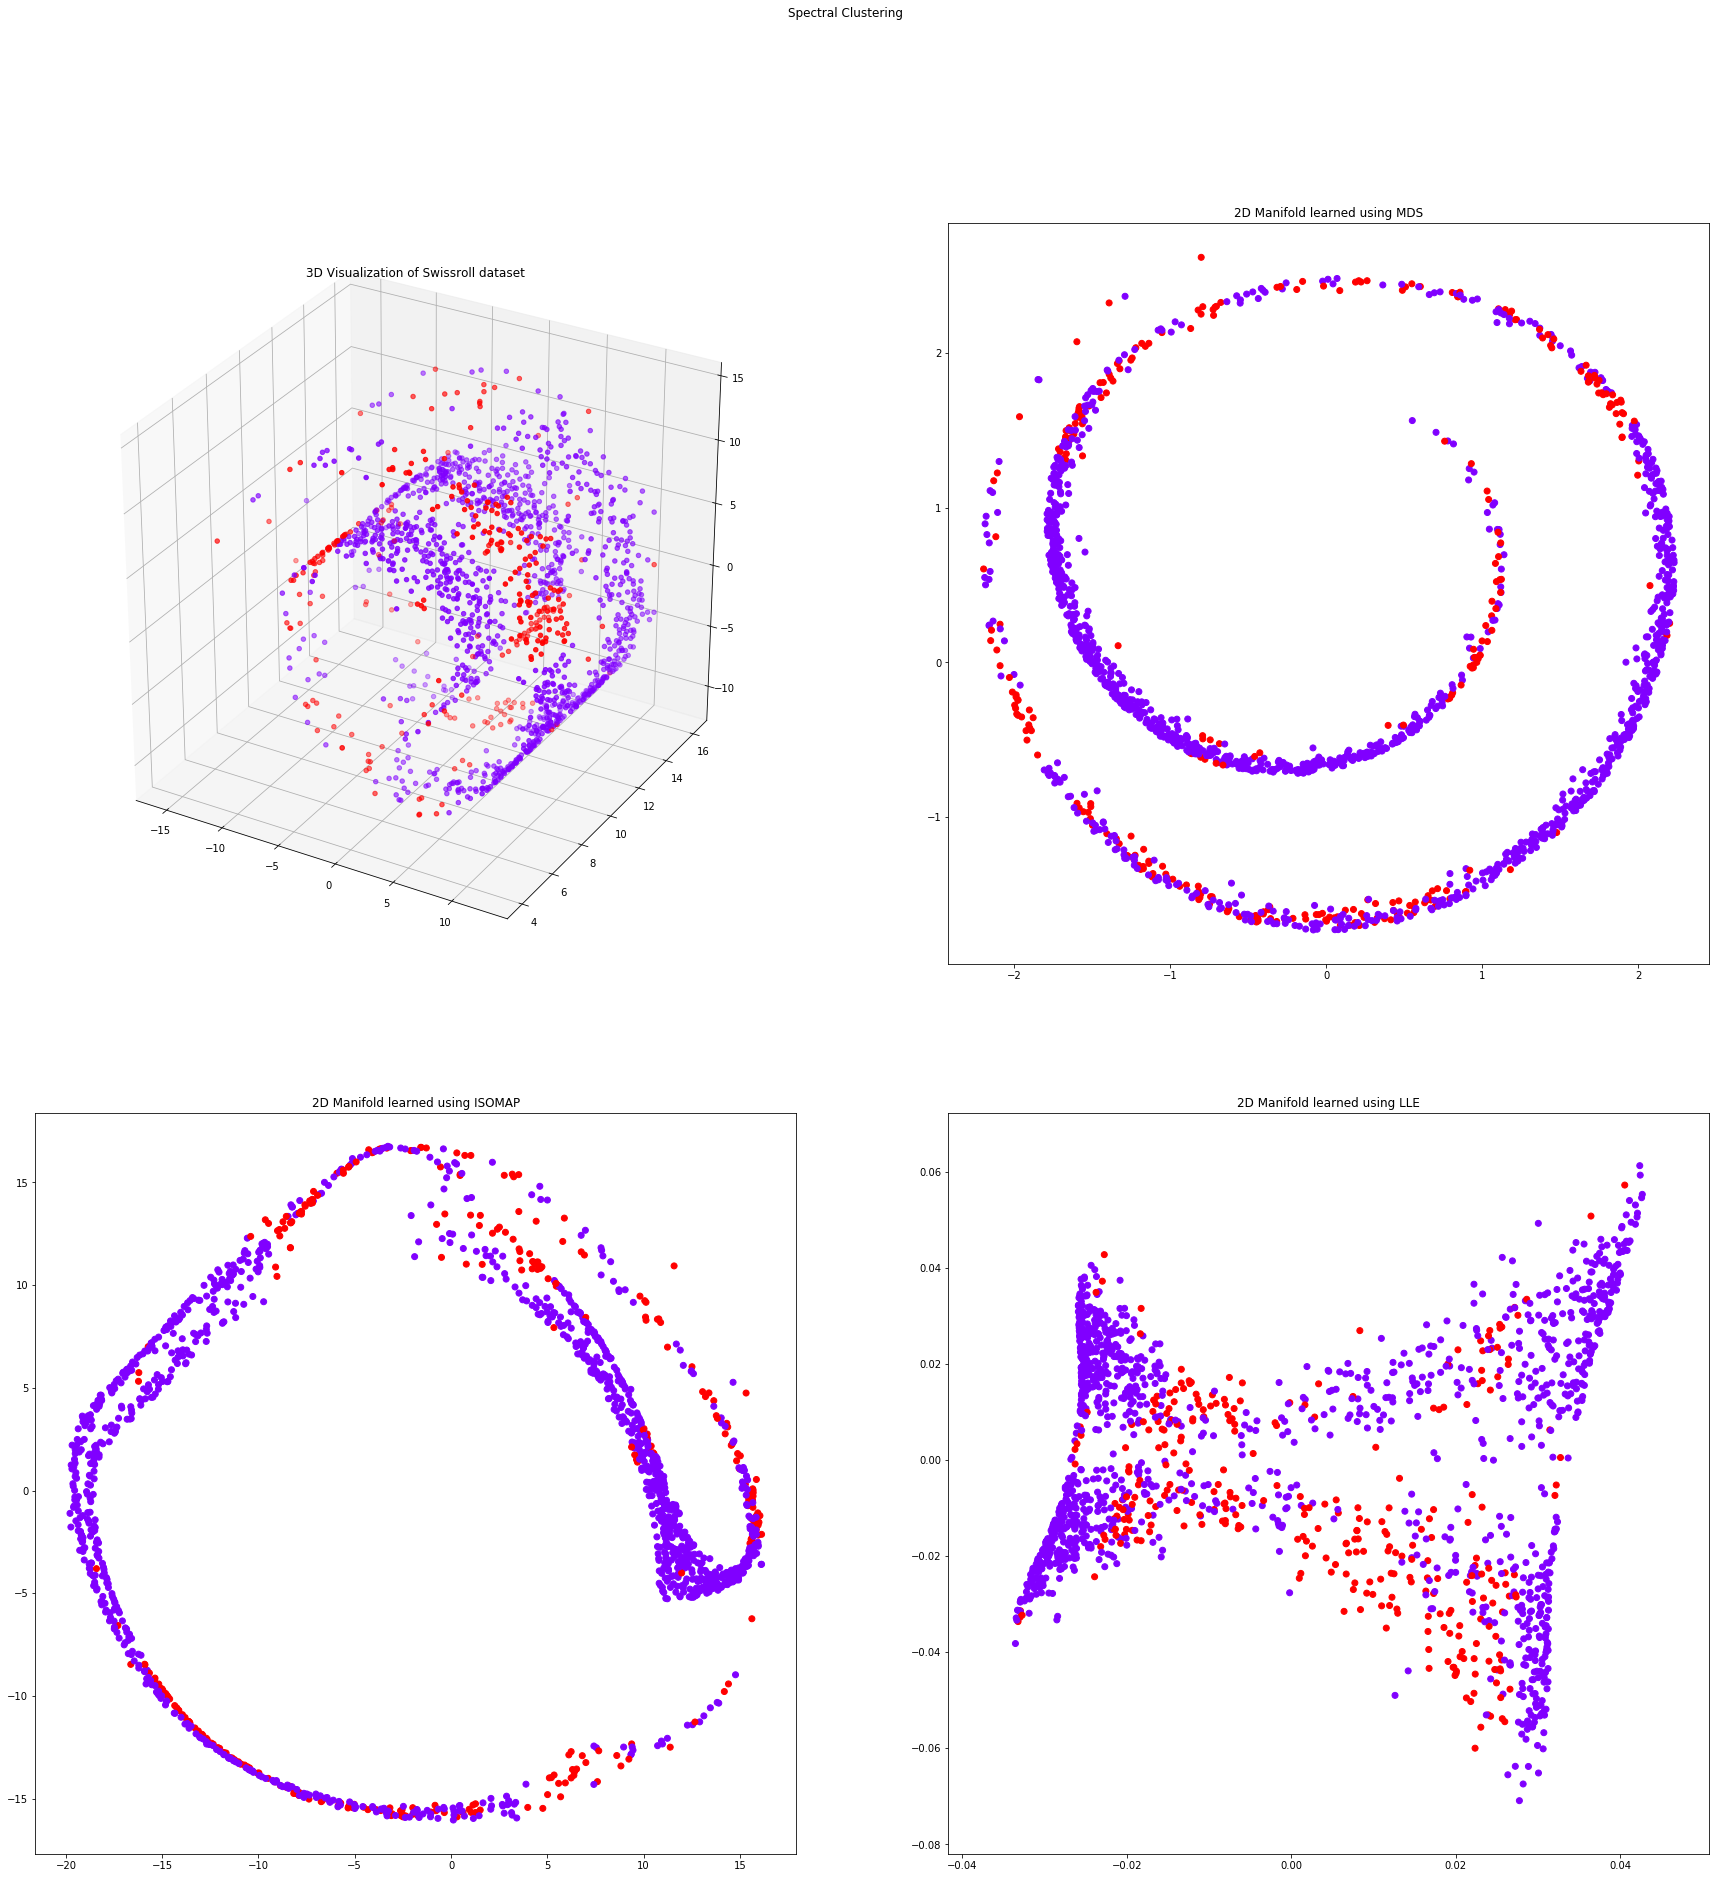

In [14]:
clusters = spectral_clustering(swissroll)
colorize = dict(c=clusters, cmap=plt.cm.get_cmap('rainbow', len(clusters)))

fig = plt.figure(figsize=(30, 30))
fig.suptitle('Spectral Clustering')

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.scatter3D(swissroll[:, 0], swissroll[:, 1], swissroll[:, 2], **colorize)
ax.set_title('3D Visualization of Swissroll dataset')

ax = fig.add_subplot(2, 2, 2)
ax.scatter(mds[:, 0], mds[:, 1], **colorize)
ax.set_title('2D Manifold learned using MDS')

ax = fig.add_subplot(2, 2, 3)
ax.scatter(isomap[:, 0], isomap[:, 1], **colorize)
ax.set_title('2D Manifold learned using ISOMAP')

ax = fig.add_subplot(2, 2, 4)
ax.scatter(lle[:, 0], lle[:, 1], **colorize)
ax.set_title('2D Manifold learned using LLE')
plt.show()

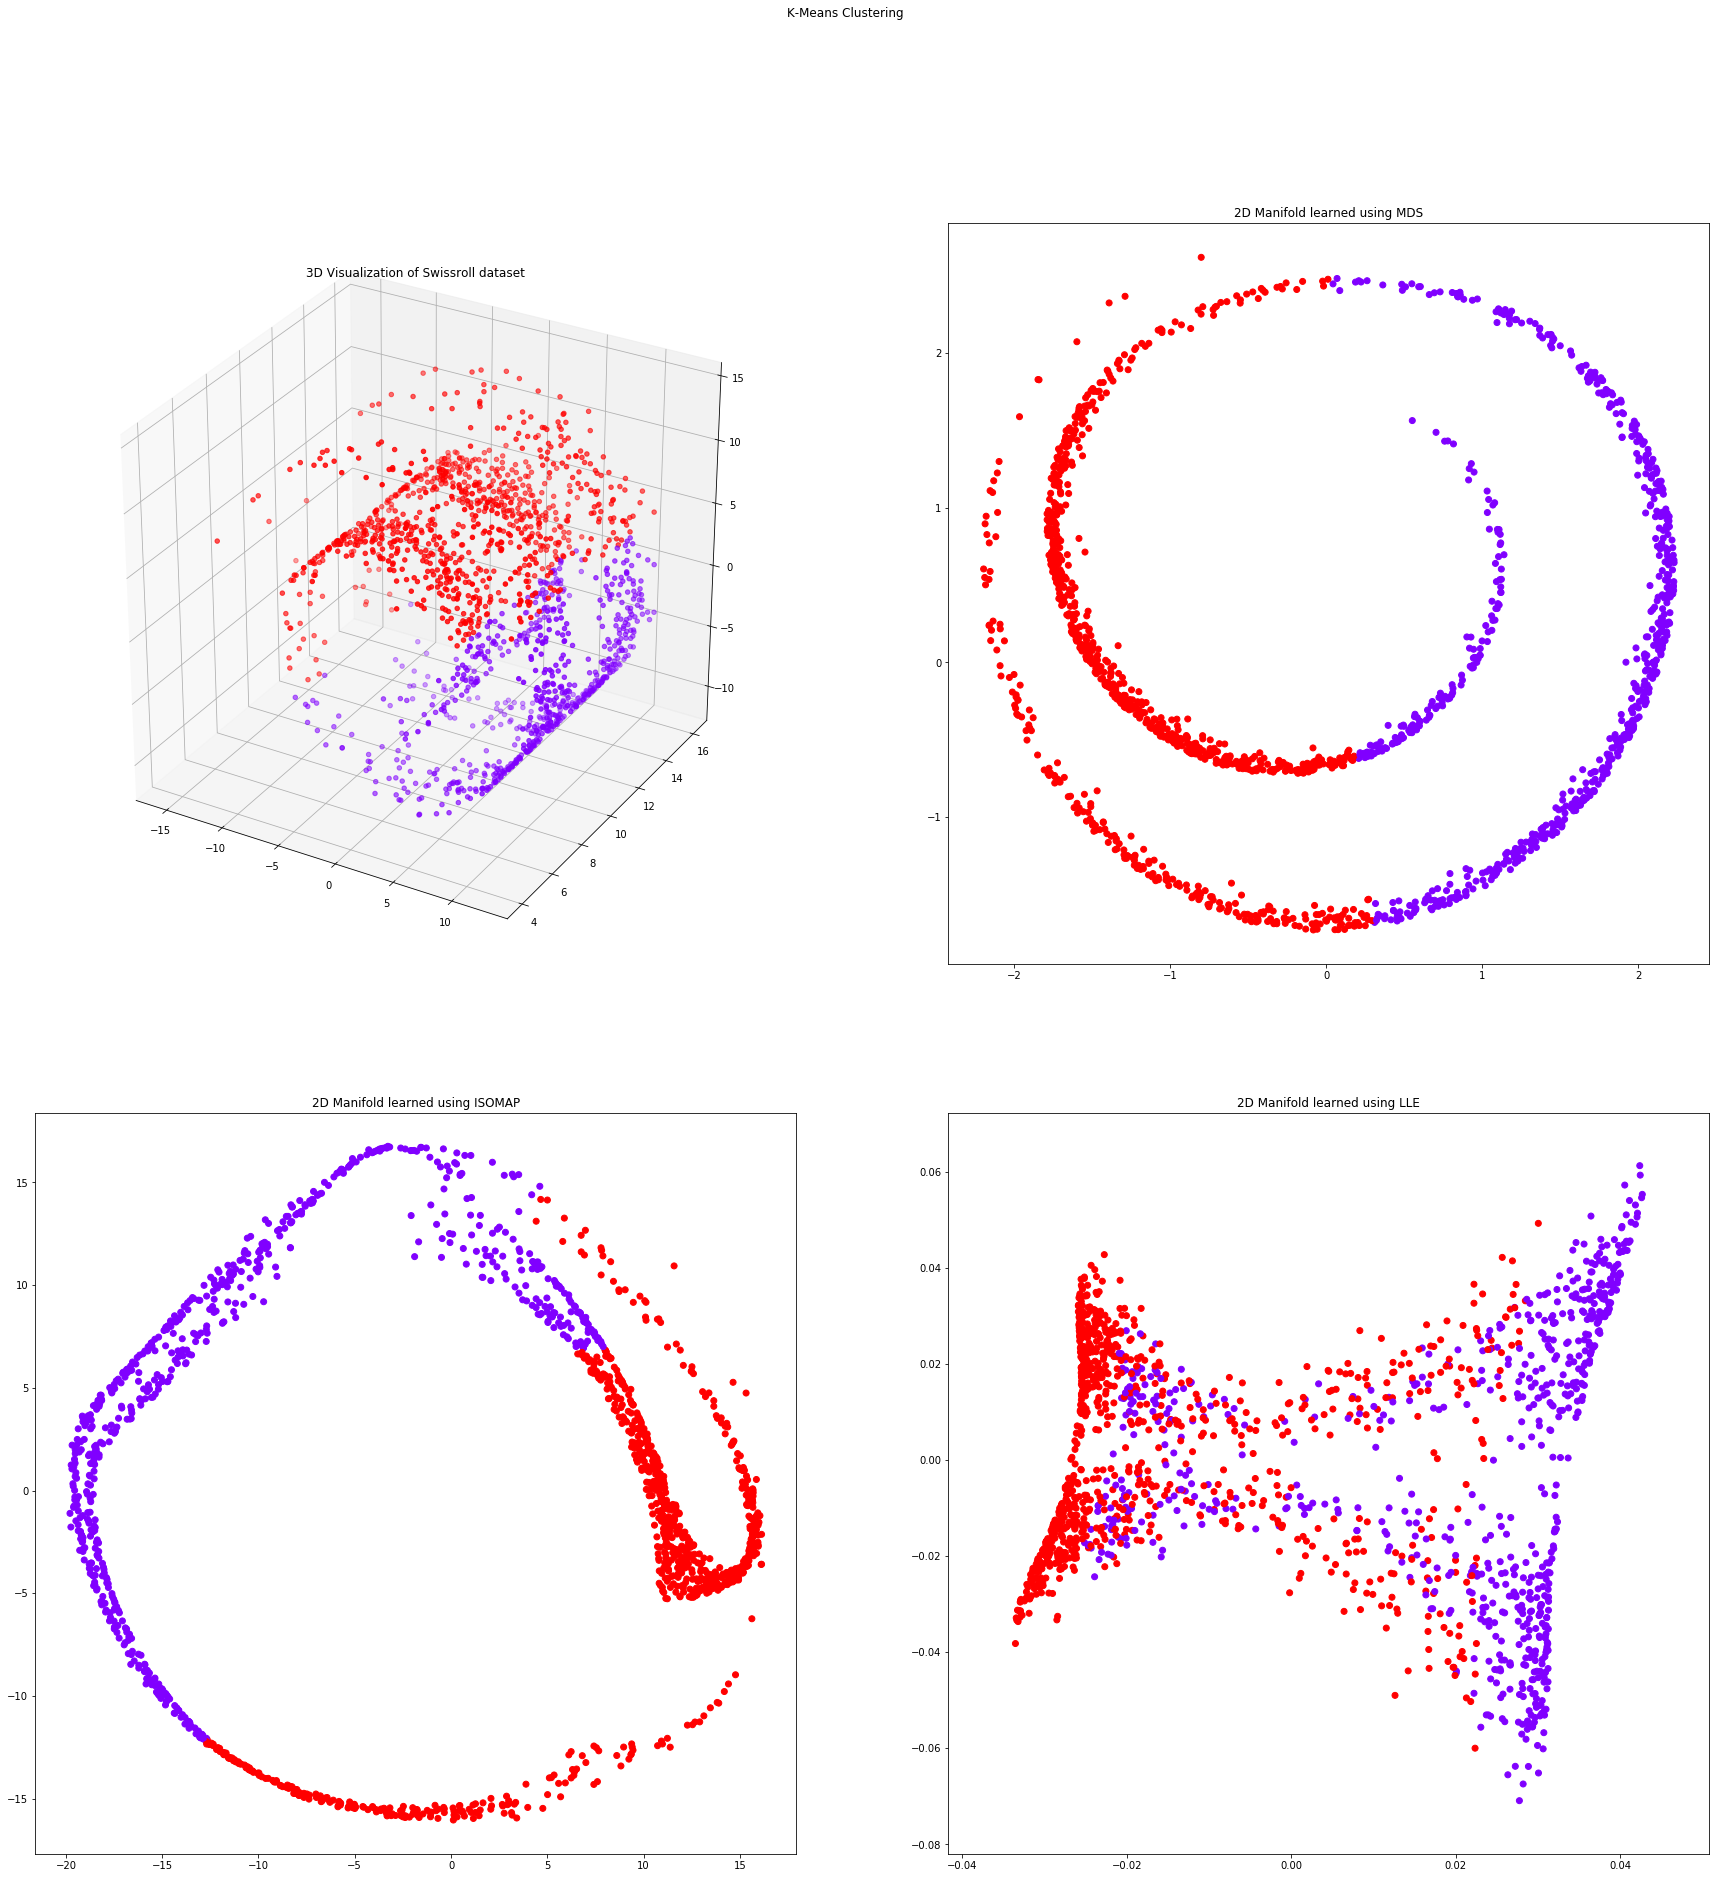

In [15]:
clusters = KMeans(n_clusters=2).fit_predict(swissroll)
colorize = dict(c=clusters, cmap=plt.cm.get_cmap('rainbow', len(clusters)))

fig = plt.figure(figsize=(30, 30))
fig.suptitle('K-Means Clustering')

ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.scatter3D(swissroll[:, 0], swissroll[:, 1], swissroll[:, 2], **colorize)
ax.set_title('3D Visualization of Swissroll dataset')

ax = fig.add_subplot(2, 2, 2)
ax.scatter(mds[:, 0], mds[:, 1], **colorize)
ax.set_title('2D Manifold learned using MDS')

ax = fig.add_subplot(2, 2, 3)
ax.scatter(isomap[:, 0], isomap[:, 1], **colorize)
ax.set_title('2D Manifold learned using ISOMAP')

ax = fig.add_subplot(2, 2, 4)
ax.scatter(lle[:, 0], lle[:, 1], **colorize)
ax.set_title('2D Manifold learned using LLE')
plt.show()

## Observations
---
- We see that MDS is not very successful in unrolling the high dimensional non-linear manifold into a linear structure. However, we do see a good visualization of the spiral shape of the *swissroll* dataset, in a lower dimensional space.
- We know that Isomap and LLE are much better suited algorithms for unrolling the non-linear manifold in lower dimensional space.
- We see that Isomap creates a good partition of the data points without intermixing. It attempts to maintain the overall distance constant even in the low dimensional space.
- LLE exhibits some amount of mixing of points, however, it preserves the locality of the points in the lower dimensional space as well, and hence appears to be somewhat of a sheet like structure. This gives us a visualization that we can interpret in terms of some approximate unfolding, as the relationship between neighbouring points is preserved.
- In terms of clustering, we see that K-Means generates a more clear and intuitive clustering than Spectral Clustering, and the points are clear and distinguished from each other in most plots. Spectral clustering, however fails, as it is very unclear, to identify which part is from which cluster (even visually by humans).

# Question 4: Classification

Perform classification using a machine learning algorithm of your choice. Use 6k images from CIFAR-10 dataset.(5k images for training and 1k images for testing.)


*   Do dimensionality reduction on the dataset using PCA and ISOMAP.
*   Apply the classification algorithm.
*   Compare the results by changing the dimensionality of the data.
*   Use F1-score as metric.
*   Approach: Reduce the dimensionality into any two dimensions(of your choice) which are less than the initial dimensionality of the data using PCA and ISOMAP. Compare the performance metrics(F1-score) for the low dimensional data.



In [16]:
# Code for loading CIFAR-10 dataset.
from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train[:5000].reshape([5000,32*32*3])
y_train = y_train[:5000]
X_test = X_test[:1000].reshape([1000,32*32*3])
y_test = y_test[:1000]
# Initial dimensionality/number of features (32*32*3) = 3072.

Using TensorFlow backend.


In [17]:
def reductionUsingPCA(X, k, output_dim):
    """Args:
        X: numpy.array [n_samples, input_dim]
        k: number of nearest neighbours to construct the knn graph
        output_dim: dimension of output data

        Returns:
        pca_X: numpy.array [n_samples, output_dim]
    """
    pca_X = PCA(n_components=output_dim).fit(X)
    return pca_X

In [18]:
def reductionUsingISOMAP(X, k, output_dim):
    """Args:
        X: numpy.array [n_samples, input_dim]
        k: number of nearest neighbours to construct the knn graph
        output_dim: dimension of output data

        Returns:
        isomap_X: numpy.array [n_samples, output_dim]
    """
    isomap_X = manifold.Isomap(n_neighbors=k, n_components=output_dim).fit(X)
    return isomap_X

In [32]:
# Classification Algorithm 
# Extra functions here

def classification(X_train, y_train, X_test, n_classes):
    """Args:
        X_train: numpy.array [n_samples, input_dim]
        y_train: numpy.array [n_samples]
        X_test: numpy.array [n_samples, input_dim]
        n_classes: number of classes

        Returns:
        labels: numpy_array [n_samples]
    """
    model = MLPClassifier(hidden_layer_sizes=(1024, 512, 256), max_iter=1000)
    model.fit(X_train, y_train)
    labels = model.predict(X_test)
    return model, labels

In [20]:
def F1_score(y_true, y_pred):
    """Args:
        y_true: numpy.array [n_samples] , ground truth value
        y_pred: numpy.array [n_samples] , predicted value by classifier

        Returns:
        score: float, f1-score
    """
    score = f1_score(y_true, y_pred, average='micro')
    return score

In [21]:
# Dimensionality reduction
PCA_1024 = reductionUsingPCA(X_train, X_train.shape[0], 1024)

In [22]:
ISOMAP_1024 = reductionUsingISOMAP(X_train, 50, 1024)

In [23]:
PCA_256 = reductionUsingPCA(X_train, X_train.shape[0], 256)

In [24]:
ISOMAP_256 = reductionUsingISOMAP(X_train, 50, 256)

In [25]:
# Dimensionality reduced data
train = {
    'PCA_1024': PCA_1024.transform(X_train),
    'ISOMAP_1024': ISOMAP_1024.transform(X_train),
    'PCA_256': PCA_256.transform(X_train),
    'ISOMAP_256': ISOMAP_256.transform(X_train)
}

In [26]:
test = {
    'PCA_1024': PCA_1024.transform(X_test),
    'ISOMAP_1024': ISOMAP_1024.transform(X_test),
    'PCA_256': PCA_256.transform(X_test),
    'ISOMAP_256': ISOMAP_256.transform(X_test)
}

In [33]:
models = {}
labels = {}
scores = {}
accuracy = {}
for key in list(train.keys()):
    models[key], labels[key] = classification(train[key], y_train.T[0, :], test[key], 10)
    scores[key] = F1_score(y_test.T[0, :], labels[key])
    accuracy[key] = accuracy_score(y_test.T[0, :], labels[key])

In [34]:
display(pd.DataFrame({'F1-score': scores}))

,F1-score
ISOMAP_1024,0.232
ISOMAP_256,0.243
PCA_1024,0.352
PCA_256,0.311


## Observations:
---
- From the table generated, we can see that classification using CIFAR-10 data that is dimensionality reduced using PCA, gives a higher F1-score than data that is reduced using Isomap.
- This can be explained as PCA being more suitable for this dataset that Isomap.
- PCA tries to minimize the reconstruction loss, and hence chooses components in the direction of maximum variance, which can be understood as directions of maximum information. This is why PCA works well for this task.
- Isomap is not suitable for this problem, however, if unlike CIFAR-10 data, the data lied on a manifold, Isomap would have be a great choice for the problem.
- We notice that with increase in dimensionality of the data, the F1-score increases, for PCA, but not Isomap. This could be because of 2 reasons
    - Unsuitability of Isomap for the problem and dataset.
    - Poor random initialization of the MLP.